In [100]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import os
from scipy.interpolate import make_interp_spline
import numpy as np
import matplotlib.dates as mpl_dates
import matplotlib as mpl
from dateutil.relativedelta import relativedelta
from datetime import datetime

In [101]:
### Import Data ###
file_paths = [
    'C:/Users/HangNTT192/Desktop/Python/202206-202211.xlsx',
    'C:/Users/HangNTT192/Desktop/Python/202212-202306.xlsx'
]

In [102]:
data_frames = [
    pd.read_excel(file_path, sheet_name=sheet_name)
    for file_path in file_paths
    for sheet_name in pd.ExcelFile(file_path).sheet_names[:-1]
]
data = pd.concat(data_frames, ignore_index=True)

In [103]:
### Data Preprocessing ###
data.dropna(inplace=True)
data['SAGYO_UNYO_DATE'] = pd.to_datetime(data['SAGYO_UNYO_DATE'], format='%Y%m%d')
data['SGY_TM'] = pd.to_datetime(data['SGY_TM'], format='%Y/%m/%d %H:%M:%S')

In [113]:
### Data Analysis ###

# Define time periods
TIME_PERIODS = {
    'prev_day': {'days': 1},
    'prev_week': {'weeks': 1},
    'prev_month': {'months': 1},
    'prev_quarter': {'months': 3},
    'prev_year': {'years': 1}
}

def get_time_period(run_date, time_period):
    if time_period in TIME_PERIODS:
        delta = relativedelta(**TIME_PERIODS[time_period])
        return run_date - delta
    else:
        raise ValueError('Invalid time period')

def compute_change_amount(df, curr_col, hist_col):
    df['CHANGE_AMOUNT'] = df[curr_col] - df[hist_col]
    df['CHANGE(%)'] = (df['CHANGE_AMOUNT'] / df[curr_col]) * 100
    df['CHANGE(%)'] = df['CHANGE(%)'].round(2)
    return df

def logistic_comparison_by_filters(logistic_df, hist_filter, curr_filter, feat):
    history_total = logistic_df[hist_filter].groupby(feat, as_index=False)['SGY_JSK_QTY'].sum()
    current_total = logistic_df[curr_filter].groupby(feat, as_index=False)['SGY_JSK_QTY'].sum()

    df = pd.merge(current_total, history_total, on=feat, suffixes=('_curr', '_hist'))
    df = compute_change_amount(df, f'SGY_JSK_QTY_curr', f'SGY_JSK_QTY_hist')

    df = df.sort_values('CHANGE(%)')
    most_likely_causes = df.nsmallest(5, 'CHANGE(%)')#.head(1)
    most_likely_causes['CATEGORY'] = feat
    most_likely_causes.rename(columns={feat: 'TITLE'}, inplace=True)
    #print(most_likely_causes)
    return most_likely_causes

def analyze_and_generate_results(logistic_df, run_date, time_period, feats, categories):
    top5_by_category = {}
    for category in categories:
        top5_by_category[category] = pd.DataFrame(columns=['TITLE', 'SGY_JSK_QTY_curr', 'SGY_JSK_QTY_hist', 'CHANGE_AMOUNT', 'CHANGE(%)', 'CATEGORY'])
        
        history_day = get_time_period(run_date, time_period)
        hist_filter_with_cate = (logistic_df['SAGYO_UNYO_DATE'] == history_day) #& (logistic_df['CATE'] == category)
        curr_filter_with_cate = (logistic_df['SAGYO_UNYO_DATE'] == run_date) #& (logistic_df['CATE'] == category)

        for feat in feats:
            top5_feat = logistic_comparison_by_filters(logistic_df, hist_filter_with_cate, curr_filter_with_cate, feat)
            top5_by_category[category] = pd.concat([top5_by_category[category], top5_feat])
        
    return top5_by_category

# Parameter Passing
run_date = datetime(2023, 4, 15)
time_period = 'prev_month'
feats = ['NIOKURI_NM', 'NIUKE_NM','CATE']
#categories = ['生活']  # You can uncomment other categories if needed

top5_by_each_category = analyze_and_generate_results(logistic_df=data, run_date=run_date, time_period=time_period, feats=feats, categories=categories)

# Access and print Top 5 of category causes changes in sub-category
for category, top5_df in top5_by_each_category.items():
    print(f"Top 5 of category causes changes in '{category}':")
    print(top5_df)



Top 5 of category causes changes in '生活':
                      TITLE SGY_JSK_QTY_curr SGY_JSK_QTY_hist CHANGE_AMOUNT  \
20              ニッケン文具　株式会社                1              315          -314   
1           アイロボットジャパン　合同会社                1               30           -29   
42              株式会社　アーキサイト                9              256          -247   
33   富士フイルムイメージングシステムズ　株式会社               40              346          -306   
60                 株式会社　ＭＴＧ                4               29           -25   
507                 豊中店(客注)                1               41           -40   
102               おしくま店(生活)               10              248          -238   
91                 ★豊岡店(ＡＶ)                1               21           -20   
68                 ★大津店(生活)                4               61           -57   
228          ホテルモントレ姫路店(生活)                3               45           -42   
4                        生活            11967            16575         -4608   
0         

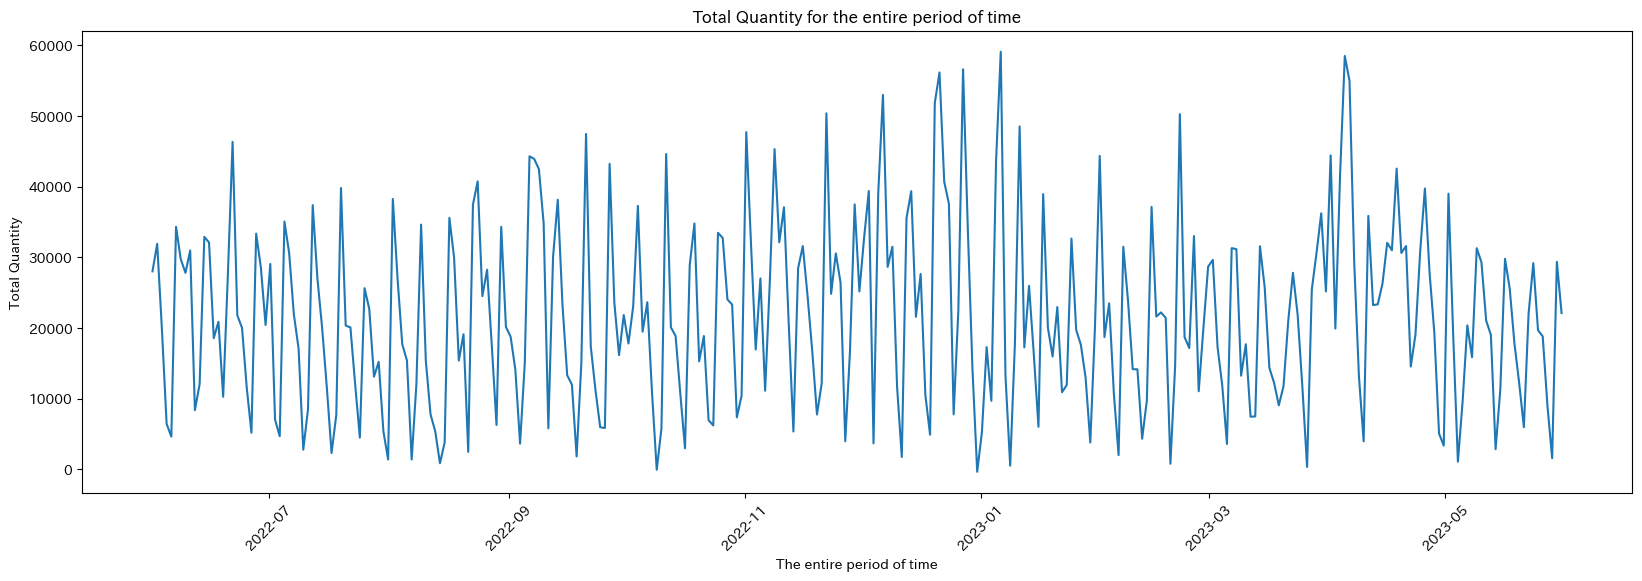

C:\Users\HangNTT192\AppData\Local\Temp\ipykernel_5252\315558297.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg1['CATEGORY'] = 'CATE'
C:\Users\HangNTT192\AppData\Local\Temp\ipykernel_5252\315558297.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg1.rename(columns={'CATE': 'TITLE'}, inplace=True)


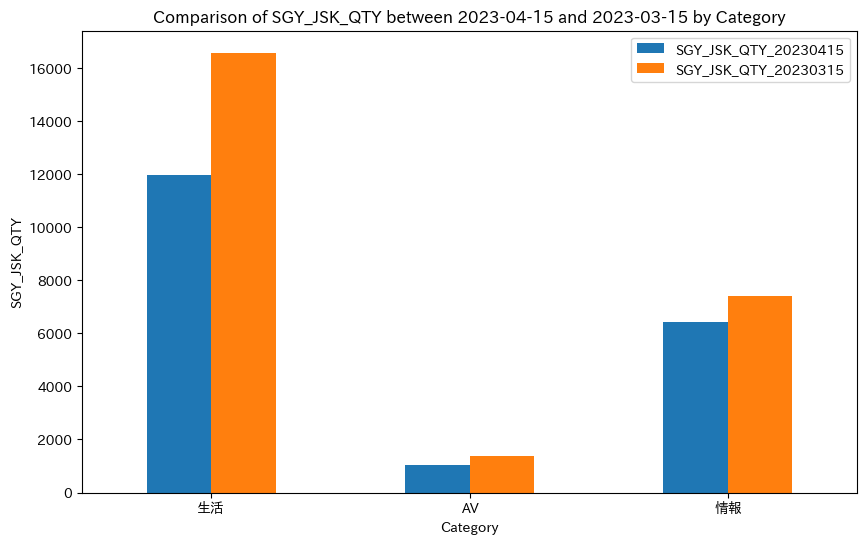

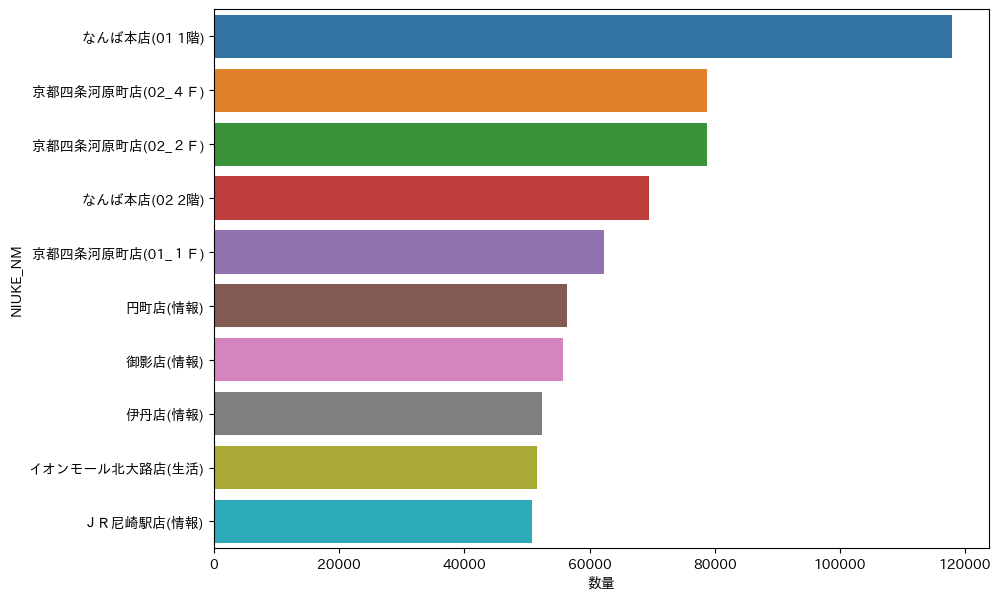

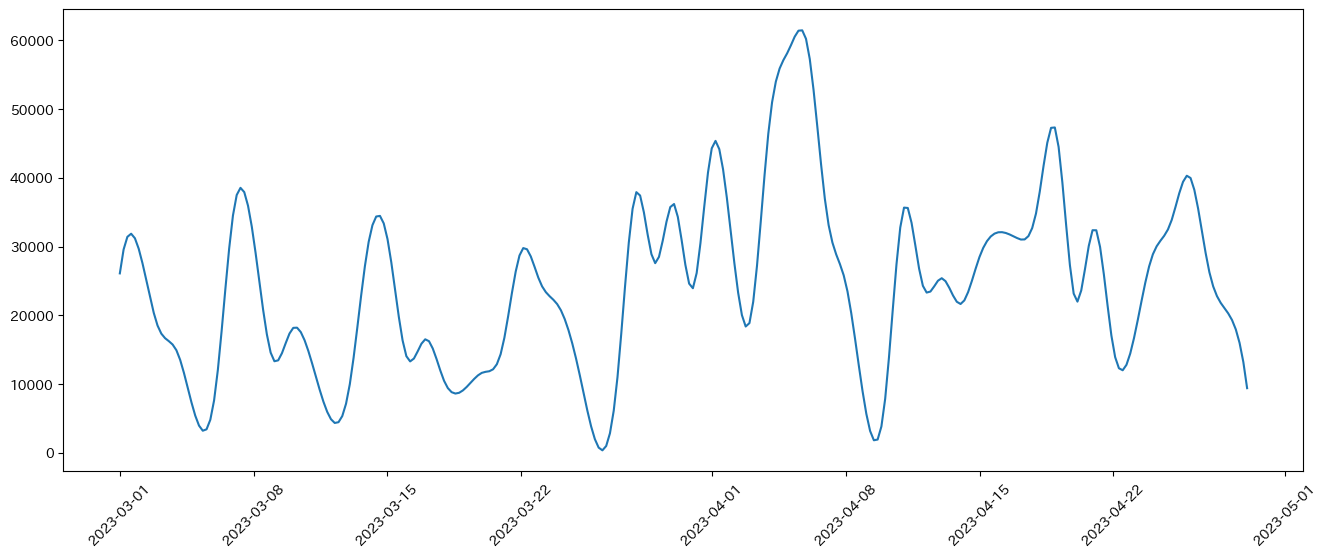

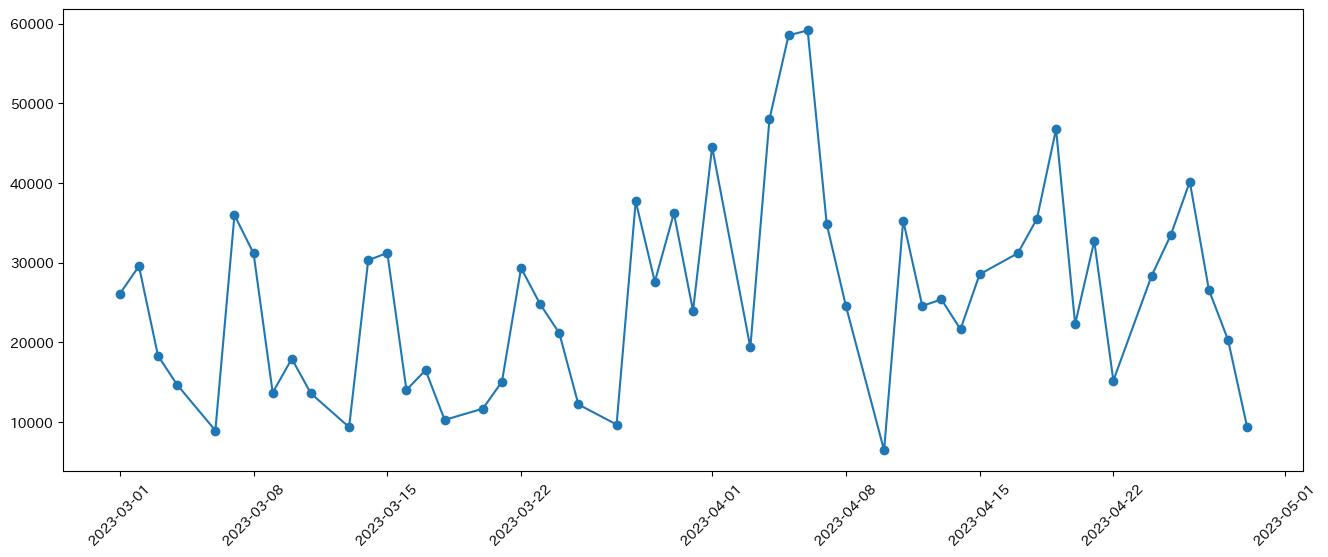

In [105]:
### Visualization ###

# Total quantity chart from 2021-06-01 to 2023-06-15（Overview)
df = data.query('SAGYO_UNYO_DATE >= "2021-06-01" & SAGYO_UNYO_DATE <= "2023-06-15"')
df_total = data.groupby(['SAGYO_UNYO_DATE'], as_index=False)['SGY_JSK_QTY'].sum()
x = mpl.dates.date2num(df_total['SAGYO_UNYO_DATE'])  # Convert dates to numeric values
y = df_total['SGY_JSK_QTY']
x_new = np.linspace(x.min(), x.max(), 300)
a_BSpline = make_interp_spline(x, y)
y_new = a_BSpline(x_new)
plt.figure(figsize=(20, 6))
plt.plot(mpl.dates.num2date(x_new), y_new)
plt.xticks(rotation=45)
plt.xlabel('The entire period of time')
plt.ylabel('Total Quantity')
plt.title('Total Quantity for the entire period of time')
plt.show()


# Total quantity chart for CATE
#Creat a time frame 
df_1 = data.query('SAGYO_UNYO_DATE=={}'.format('20230415'))
df_2 = data.query('SAGYO_UNYO_DATE=={}'.format('20230315'))
FEAT = ['CATE']
total2 = df_2.groupby(FEAT, as_index=False)['SGY_JSK_QTY'].sum()
total1 = df_1.groupby(FEAT, as_index=False)['SGY_JSK_QTY'].sum()
df = pd.merge(total1, total2, on=FEAT)
df.columns = FEAT + ['{}_{}'.format('SGY_JSK_QTY', '20230415')] + ['{}_{}'.format('SGY_JSK_QTY', '20230315')]
df['CHANGE AMOUNT'] = df['SGY_JSK_QTY_20230415'] - df['SGY_JSK_QTY_20230315']
df['CHANGE(%)'] = (df['CHANGE AMOUNT'] / df['SGY_JSK_QTY_20230415']) *100
df['CHANGE(%)'] = df['CHANGE(%)'].round(2)
df = df.sort_values('CHANGE(%)')
df1 = df.reset_index()
df_neg1 = df.query('`CHANGE(%)` < 0')
df_neg1['CATEGORY'] = 'CATE'
df_neg1.rename(columns={'CATE': 'TITLE'}, inplace=True)
df_neg1.head(5)
# Set the title, SGY_JSK_QTY_20230415, and SGY_JSK_QTY_20230315 columns as index for the DataFrame
df_neg1.set_index('TITLE', inplace=True)
# Plotting the bar chart
ax = df_neg1[['SGY_JSK_QTY_20230415', 'SGY_JSK_QTY_20230315']].plot(kind='bar', rot=0, figsize=(10, 6))
# Add labels and title
plt.xlabel('Category')
plt.ylabel('SGY_JSK_QTY')
plt.title('Comparison of SGY_JSK_QTY between 2023-04-15 and 2023-03-15 by Category')
# Show the plot
plt.show()


# Total quantity chart for NIUKE_NM
# Group the data by category and calculate the total quantity
grouped_data = data.groupby('NIUKE_NM')['SGY_JSK_QTY'].sum().reset_index()
# Sort the data by quantity in descending order
sorted_data = grouped_data.sort_values('SGY_JSK_QTY', ascending=False).head(10)
# Plot the bar chart
plt.figure(figsize=(10,7))
sns.barplot(data=sorted_data, x='SGY_JSK_QTY', y='NIUKE_NM')
plt.xlabel('数量')
plt.ylabel('NIUKE_NM')
plt.show()


# Total quantity chart for the period of time
df = data[(data['SAGYO_UNYO_DATE']>="2023-03-01")&(data['SAGYO_UNYO_DATE']<="2023-04-30")]
df_total = df.groupby(['SAGYO_UNYO_DATE'], as_index=False)['SGY_JSK_QTY'].sum()

x = mpl.dates.date2num(df_total['SAGYO_UNYO_DATE'])  # Convert dates to numeric values
y = df_total['SGY_JSK_QTY']

x_new = np.linspace(x.min(), x.max(), 300)
a_BSpline = make_interp_spline(x, y)
y_new = a_BSpline(x_new)

plt.figure(figsize=(16, 6))
plt.plot(mpl.dates.num2date(x_new), y_new)
plt.xticks(rotation=45)
plt.figure(figsize=(16, 6))
plt.plot(df_total['SAGYO_UNYO_DATE'], df_total['SGY_JSK_QTY'], marker='o')
plt.xticks(rotation=45)
plt.show()

In [106]:
input_startDate = pd.to_datetime('2022-06-11')
input_endDate = pd.to_datetime('2022-06-13')
num_days = (input_endDate - input_startDate).days

compare_startDate = pd.to_datetime('2022-07-11')
compare_endDate = pd.to_datetime('2022-07-13')

df_origin = data[(data['SAGYO_UNYO_DATE'] >= input_startDate) & (data['SAGYO_UNYO_DATE'] <= input_endDate)]
column_names = ['CATE','NIOKURI_NM','CAPA', 'TANKA','NIUKE_NM','KATAMEI','FD_BUNRUI']

# W-1 
w_minus1_startDate = input_startDate - timedelta(days=7)
w_minus1_endDate = w_minus1_startDate + timedelta(days=num_days)
print("Week-1 Start Date:", w_minus1_startDate.date())
print("Week-1 End Date:", w_minus1_endDate.date())
# W + 1
w_plus1_startDate = input_startDate + timedelta(days=7)
w_plus1_endDate = w_plus1_startDate + timedelta(days=num_days)
print("Week+1 Start Date:", w_plus1_startDate.date())
print("Week+1 End Date:", w_plus1_endDate.date())
# M - 1
m_minus1_startDate = input_startDate - relativedelta(months=1)
m_minus1_endDate = m_minus1_startDate + timedelta(days=num_days)
print("Month-1 Start Date:", m_minus1_startDate.date())
print("Month-1 End Date:", m_minus1_endDate.date())
# M + 1
m_plus1_startDate = input_startDate + relativedelta(months=1)
m_plus1_endDate = m_plus1_startDate + timedelta(days=num_days)
print("Month+1 Start Date:", m_plus1_startDate.date())
print("Month+1 End Date:", m_plus1_endDate.date())
# Quarter - 1 
q_minus1_startDate = input_startDate - relativedelta(months=3)
q_minus1_endDate = q_minus1_startDate + timedelta(days=num_days)
print("Quarter - 1 Start Date:", q_minus1_startDate.date())
print("Quarter - 1 End Date:", q_minus1_endDate.date())
# Quarter + 1
q_plus1_startDate = input_startDate + relativedelta(months=3)
q_plus1_endDate = q_plus1_startDate + timedelta(days=num_days)
print("Quarter + 1 Start Date:", q_plus1_startDate.date())
print("Quarter + 1 End Date:", q_plus1_endDate.date())
# Year - 1
y_minus1_startDate = input_startDate - relativedelta(years=1)
y_minus1_endDate = y_minus1_startDate + timedelta(days=num_days)
print("Year - 1 Start Date:", y_minus1_startDate.date())
print("Year - 1 End Date:", y_minus1_endDate.date())
# Year + 1
y_plus1_startDate = input_startDate + relativedelta(years=1)
y_plus1_endDate = y_plus1_startDate + timedelta(days=num_days)
print("Year + 1 Start Date:", y_plus1_startDate.date())
print("Year + 1 End Date:", y_plus1_endDate.date())

NameError: name 'timedelta' is not defined

In [ ]:
def calculation(variable_name, startDate, endDate):
    df_compare = data[(data['SAGYO_UNYO_DATE'] >= startDate) & (data['SAGYO_UNYO_DATE'] <= endDate)]
    if len(df_compare) <= 0:
        return 
    sum_df1 = df_origin.groupby(variable_name, as_index=False)['SGY_JSK_QTY'].sum()
    # Compare with range date
    sum_df2 = df_compare.groupby(variable_name, as_index=False)['SGY_JSK_QTY'].sum()
    df = pd.merge(sum_df1, sum_df2, on=variable_name)
    # df = df
    df.columns = ['TYPE']  +  ['SGY_JSK_QTY_x'] +  ['SGY_JSK_QTY_y']
    df['CHANGE_AMOUNT'] = df['SGY_JSK_QTY_x'] - df['SGY_JSK_QTY_y']
    df['CHANGE(%)'] = (df['CHANGE_AMOUNT']/df['SGY_JSK_QTY_x'] * 100).round(2)
    df['COLUMN_NAME'] = variable_name
    df = df.sort_values('CHANGE(%)').query("CHANGE_AMOUNT < 0").head(1)
    return df
def call_calculation(startDate, endDate):
    df_full = pd.DataFrame()
    for col_name in column_names:
        df = calculation(col_name, startDate, endDate)
        df_full = pd.concat([df_full, df])

    df_full.reset_index(drop=True, inplace=True)
    # add an index column starting from 1
    df_full.index = df_full.index + 1
    return df_full

df_intput_compare = call_calculation(compare_startDate, compare_endDate)
print('compare')
print(df_intput_compare)
# week - 1 & w + 1
dfw_minus1 = call_calculation(w_minus1_startDate, w_minus1_endDate)
print('week -1')
print(dfw_minus1)
dfw_plus1 = call_calculation(w_plus1_startDate, w_plus1_endDate)
print('week + 1')
print(dfw_plus1)
# month - 1 & M +1
dfm_minus1 = call_calculation(m_minus1_startDate, m_minus1_endDate)
print('month -1')
print(dfm_minus1)
dfm_plus1 = call_calculation(m_plus1_startDate, m_plus1_endDate)
print('month + 1')
print(dfm_plus1)
# Quarter - 1 & Q + 1
dfq_minus1 = call_calculation(q_minus1_startDate, q_minus1_endDate)
print('quarter -1')
print(dfq_minus1)
dfq_plus1 = call_calculation(q_plus1_startDate, q_plus1_endDate)
print('quarter + 1')
print(dfq_plus1)
# Year - 1 & Year + 1
dfy_minus1 = call_calculation(y_minus1_startDate, y_minus1_endDate)
print('year -1')
print(dfy_minus1)
dfy_plus1 = call_calculation(y_plus1_startDate, y_plus1_endDate)
print('year + 1')
print(dfy_plus1)

compare
        TYPE  SGY_JSK_QTY_x  SGY_JSK_QTY_y  CHANGE_AMOUNT  CHANGE(%)  \
1         情報           6398          24323         -17925    -280.17   
2  株式会社　浅沼商会              1             70            -69   -6900.00   
3    0.00002             29           6673          -6644  -22910.34   
4        786              1            208           -207  -20700.00   
5    枚方店(客注)              1             43            -42   -4200.00   
6   LR03R/4S             27           6643          -6616  -24503.70   
7   63705151              1             89            -88   -8800.00   

  COLUMN_NAME  
1        CATE  
2  NIOKURI_NM  
3        CAPA  
4       TANKA  
5    NIUKE_NM  
6     KATAMEI  
7   FD_BUNRUI  
week -1
             TYPE  SGY_JSK_QTY_x  SGY_JSK_QTY_y  CHANGE_AMOUNT  CHANGE(%)  \
1             理美容           1294           2869          -1575    -121.72   
2        シロカ　株式会社              4            104           -100   -2500.00   
3        0.002652              3            304 